# Looking at CCFs and Plotting

In [212]:
import os
import glob
import numpy as np
import pandas as pd
from scipy import interpolate
from astropy.io import fits
import matplotlib.pyplot as plt

import tamar.tools.utilities as utils
import tamar.tools.ccf_funcs as ccffuncs
from tamar.tools.settings import CsvDir, ImgDir, PlotDir


In [213]:
# mpl settings
plot_style = os.path.join(PlotDir.MPL, 'timeseries.mplstyle')
plt.style.use(plot_style)

Read in my velocity calculations.

In [214]:
# get the dates
csv_name = os.path.join(CsvDir.NEID_CALC, 'rvs_from_fits.csv')
df = pd.read_csv(csv_name)

jd = df.date_jd.values
dates = [utils.get_neid_struct_dates(d) for d in jd]
dates = [d[0] for d in dates]
# get the model velocities
# TODO: right now using sun velocities because of issue with scaling factors
rv_model = df.rv_sun.values
rv_model /= 1e3

Read in fits file.

In [215]:
# specify which directory contains all of the fits files
neid_days = os.listdir(CsvDir.NEID_SOLAR)

## Active Sun CCF

In [216]:
date = '20210223'
spec_path = os.path.join(CsvDir.NEID_SOLAR, date, 'level2', date)

# search for all fits files within 'spec_path'
spec_fits_files = [i for i in glob.glob(os.path.join(spec_path,'*.fits'))]
if len(spec_fits_files) < 1:
    print('no fits files found!')

Get CCF fits header and actual CCF data.

In [217]:
# get ccf header
ccf_header = fits.getheader(spec_fits_files[0], 'CCFS')

# get wavelength information
fib = 'SCI' # SCIENCE fiber
fits_extension_spectrum = fib + 'FLUX' # this is how we catalog the different bits of NEID data
fits_extension_variance = fib + 'VAR' # variance (noise) extension of fits file
fits_extension_wavelength = fib + 'WAVE'
wvl = fits.getdata(spec_fits_files[0], fits_extension_wavelength) / 10.

In [218]:
# read in all CCFs
ccfs = fits.getdata(spec_fits_files[0], 'CCFS')
nord = ccfs.shape[0]

# reconstruct the velocity scale for these CCFs using information in the FITS header
vel_start = fits.getheader(spec_fits_files[0], 'CCFS')['CCFSTART']
vel_step = fits.getheader(spec_fits_files[0], 'CCFS')['CCFSTEP']
nvels = fits.getheader(spec_fits_files[0], 'CCFS')['NAXIS1']
vel_arr = np.arange(vel_start, vel_start + nvels * vel_step, vel_step)

# get radial velocity value for spectral shift from calculations
rv_shift = fits.getheader(spec_fits_files[0], 'CCFS')['CCFRVMOD']
# rv_shift = rv_model[np.isin(dates, [date])][0]

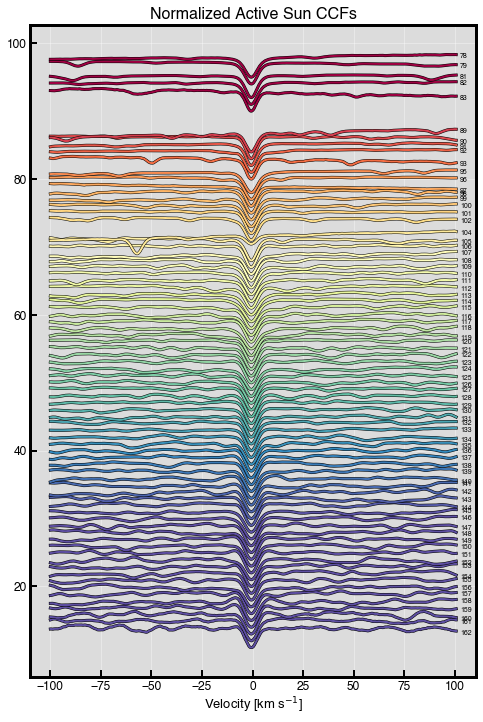

In [219]:
# set some plotting parameters
Col = plt.get_cmap('Spectral')
plt.rcParams['figure.figsize'] = [8, 12]

# ignore division error
np.seterr(divide='ignore', invalid='ignore')

# plot each order cross-correlation function
for ind, order in enumerate(range(nord)):
    wvl_norm = 1. - (np.mean(wvl[ind,:]) - 420.) / (720. - 420.)
    ccf = ccfs[ind,:]
    ccf_scaled = (ccf - np.amin(ccf))
    ccf_scaled /= max(ccf_scaled) * 0.3
    ccf_scaled += ind
    plt.plot(vel_arr, ccf_scaled, c='black', linewidth=3)
    plt.plot(vel_arr, ccf_scaled, c=Col(wvl_norm), lw=2.)
    plt.annotate(str(173 - ind), (max(vel_arr) + 2., ccf_scaled[-1] - 0.5), fontsize=7)

plt.title('Normalized Active Sun CCFs')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()

## Choose a quiet-Sun day to look at.

In [220]:
date = '20210207'
spec_path = os.path.join(CsvDir.NEID_SOLAR, date, 'level2', date)

# search for all fits files within 'spec_path'
spec_fits_files = [i for i in glob.glob(os.path.join(spec_path,'*.fits'))]
if len(spec_fits_files) < 1:
    print('no fits files found!')

Get CCF fits header and actual CCF data.

In [221]:
# get ccf header
ccf_header = fits.getheader(spec_fits_files[0], 'CCFS')

# get wavelength information
q_wvl = fits.getdata(spec_fits_files[0], fits_extension_wavelength) / 10.

In [222]:
# read in all CCFs
q_ccfs = fits.getdata(spec_fits_files[0], 'CCFS')
q_nord = ccfs.shape[0]

# reconstruct the velocity scale for these CCFs using information in the FITS header
q_vel_start = fits.getheader(spec_fits_files[0], 'CCFS')['CCFSTART']
q_vel_step = fits.getheader(spec_fits_files[0], 'CCFS')['CCFSTEP']
q_nvels = fits.getheader(spec_fits_files[0], 'CCFS')['NAXIS1']
q_vel_arr = np.arange(vel_start, vel_start + nvels * vel_step, vel_step)

# rv value from fits file for spectral shift
q_rv_shift = fits.getheader(spec_fits_files[0], 'CCFS')['CCFRVMOD']
# q_rv_shift = rv_model[np.isin(dates, [date])][0]

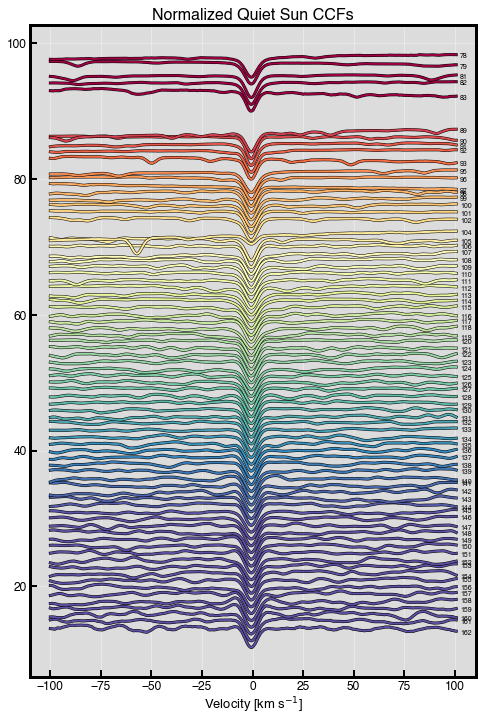

In [223]:
# set some plotting parameters
Col = plt.get_cmap('Spectral')
plt.rcParams['figure.figsize'] = [8, 12]

# ignore division error
np.seterr(divide='ignore', invalid='ignore')

# plot each order cross-correlation function
for ind, order in enumerate(range(q_nord)):
    wvl_norm = 1. - (np.mean(q_wvl[ind,:]) - 420.) / (720. - 420.)
    ccf = q_ccfs[ind,:]
    ccf_scaled = (ccf - np.amin(ccf))
    ccf_scaled /= max(ccf_scaled) * 0.3
    ccf_scaled += ind
    plt.plot(q_vel_arr, ccf_scaled, c='black', linewidth=3)
    plt.plot(q_vel_arr, ccf_scaled, c=Col(wvl_norm), lw=2.)
    plt.annotate(str(173 - ind), (max(q_vel_arr) + 2., ccf_scaled[-1] - 0.5), fontsize=7)

plt.title('Normalized Quiet Sun CCFs')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()


## Look at the residuals of an order.

In [224]:
residuals = [ccfs[ind,:] - q_ccfs[ind,:] for ind in range(q_nord)]

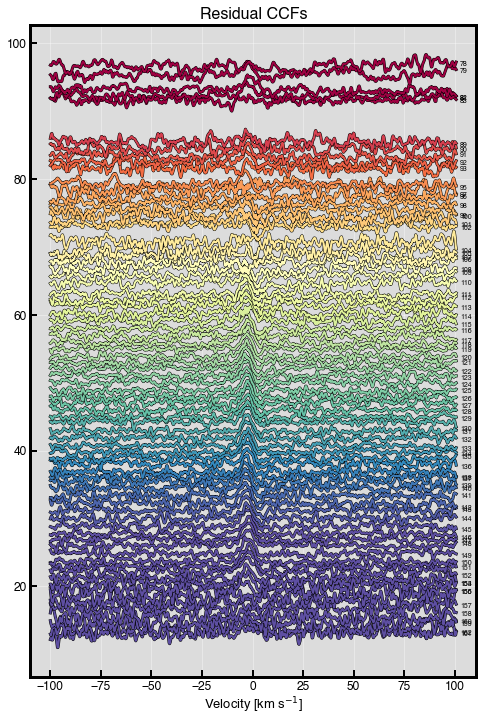

<Figure size 576x864 with 0 Axes>

In [225]:
# plot each order cross-correlation function
for ind, order in enumerate(range(q_nord)):
    wvl_norm = 1. - (np.mean(q_wvl[ind,:]) - 420.) / (720. - 420.)
    ccf = residuals[ind]
    ccf_scaled = (ccf - np.amin(ccf))
    ccf_scaled /= max(ccf_scaled) * 0.3
    ccf_scaled += ind
    plt.plot(q_vel_arr, ccf_scaled, c='black', linewidth=3)
    plt.plot(q_vel_arr, ccf_scaled, c=Col(wvl_norm), lw=2.)
    plt.annotate(str(173 - ind), (max(q_vel_arr) + 2., ccf_scaled[-1] - 0.5), fontsize=7)

plt.title('Residual CCFs')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()

plt.savefig(os.path.join(ImgDir.CCF_IMG, 'residual_ccfs.png'))

In [226]:
# plot quiet-Sun CCF
ccf = q_ccfs[40,:]
q_scaled = (ccf - np.amin(ccf))
q_scaled /= max(q_scaled) # * 0.3
# q_scaled += ind

# plot active sun CCF
ccf = ccfs[40,:]
a_scaled = (ccf - np.amin(ccf))
a_scaled /= max(a_scaled) # * 0.3
# a_scaled += ind

# get residual
residual = ccfs[40,:] - q_ccfs[40,:]
ccf = residual
r_scaled = (ccf - np.amin(ccf))
r_scaled /= max(r_scaled) # * 0.3
# r_scaled += ind

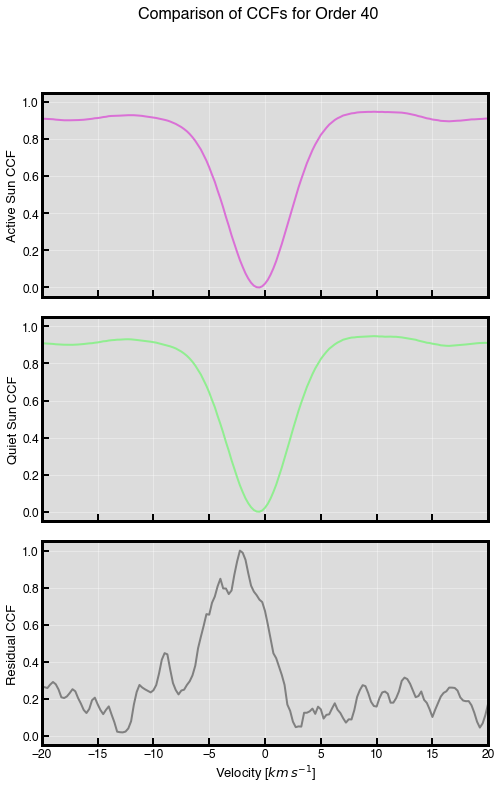

In [227]:
# plot them
fig, axs = plt.subplots(3, sharex='all', gridspec_kw={'hspace': 0.1})
plt.rcParams['figure.figsize'] = [12, 6]
axs[0].plot(q_vel_arr, a_scaled, c='orchid', linewidth=2)
axs[1].plot(q_vel_arr, q_scaled, c='lightgreen', linewidth=2)
axs[2].plot(q_vel_arr, r_scaled, c='grey', linewidth=2)
axs[0].set_ylabel('Active Sun CCF')
axs[1].set_ylabel('Quiet Sun CCF')
axs[2].set_ylabel('Residual CCF')
plt.xlabel('Velocity [$km\/s^{-1}$]')
plt.xlim(-20, 20)
plt.suptitle('Comparison of CCFs for Order ' + str(range(nord)[40]))
plt.savefig(os.path.join(ImgDir.CCF_IMG, 'residual_ccfs.png'))



# Do the same for full CCFs

In [228]:
# load reference weights file
ccf_weights = np.load('../../example_notebooks_and_data/ord_weights_test.npy')

In [229]:
data_spec = fits.getdata(spec_fits_files[0], fits_extension_spectrum)

# initialize arrays
ccfs_scaled = np.zeros_like(ccfs)
ccf_sums = []

# loop through each order an"d normalized the CCFs to their integrated areas
nords = data_spec.shape[0]
for ord_n in range(nords):
    ccf_sum = np.nansum(ccfs[ord_n, :])
    ccf_sums.append(ccf_sum)

    # apply weighting scheme to each order -- probs an easier way to do this with matrix math, but this is more explicit
    ccfs_scaled[ord_n,:] = (ccfs[ord_n,:] / ccf_sum) * ccf_weights[ord_n]

In [230]:
# sum up all of the weighted CCFs to make the 'final' CCF
ccf_weighted = np.nansum(ccfs_scaled, axis=0)

# normalize
ccf_weighted /= np.nanmax(ccf_weighted)

In [231]:
# shift ccf
ccf_shift = ccffuncs.ccf_shift(vel_arr, ccf_weighted, rv_shift)

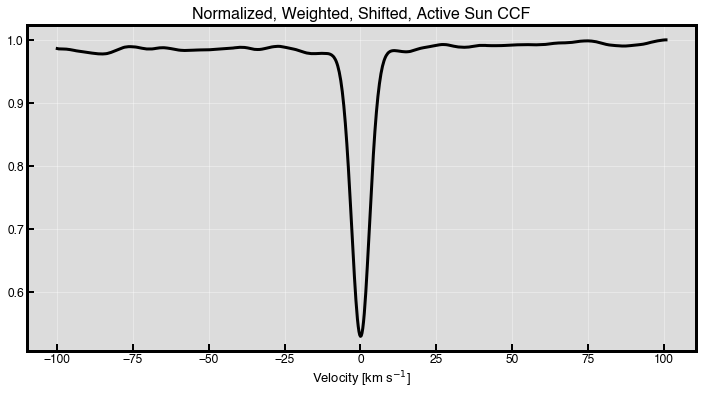

In [232]:
# plot
plt.plot(vel_arr, ccf_shift, c='black', linewidth=3)
plt.title('Normalized, Weighted, Shifted, Active Sun CCF')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()

In [233]:
# initialize arrays
q_ccfs_scaled = np.zeros_like(q_ccfs)
ccf_sums = []

# loop through each order an"d normalized the CCFs to their integrated areas
nords = data_spec.shape[0]
for ord_n in range(nords):
    ccf_sum = np.nansum(q_ccfs[ord_n, :])
    ccf_sums.append(ccf_sum)

    # apply weighting scheme to each order -- probs an easier way to do this with matrix math, but this is more explicit
    q_ccfs_scaled[ord_n,:] = (q_ccfs[ord_n,:] / ccf_sum) * ccf_weights[ord_n]

In [234]:
# sum up all of the weighted CCFs to make the 'final' CCF
q_ccf_weighted = np.nansum(q_ccfs_scaled, axis=0)

# normalize
q_ccf_weighted /= np.nanmax(q_ccf_weighted)

In [235]:
# shift ccf
q_ccf_shift = ccffuncs.ccf_shift(q_vel_arr, q_ccf_weighted, q_rv_shift)


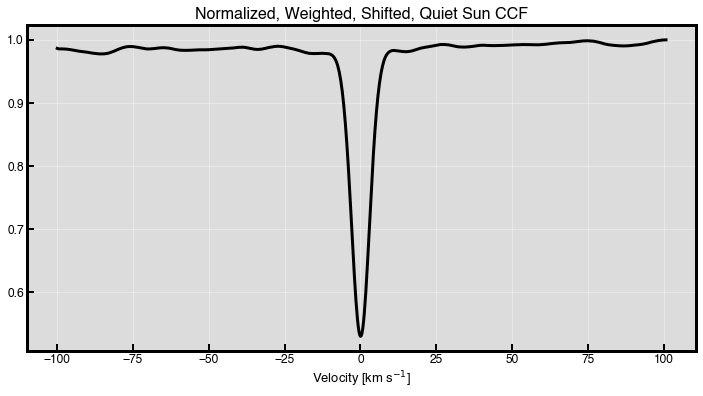

In [236]:
# plot
plt.plot(q_vel_arr, q_ccf_shift, c='black', linewidth=3)
plt.title('Normalized, Weighted, Shifted, Quiet Sun CCF')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()

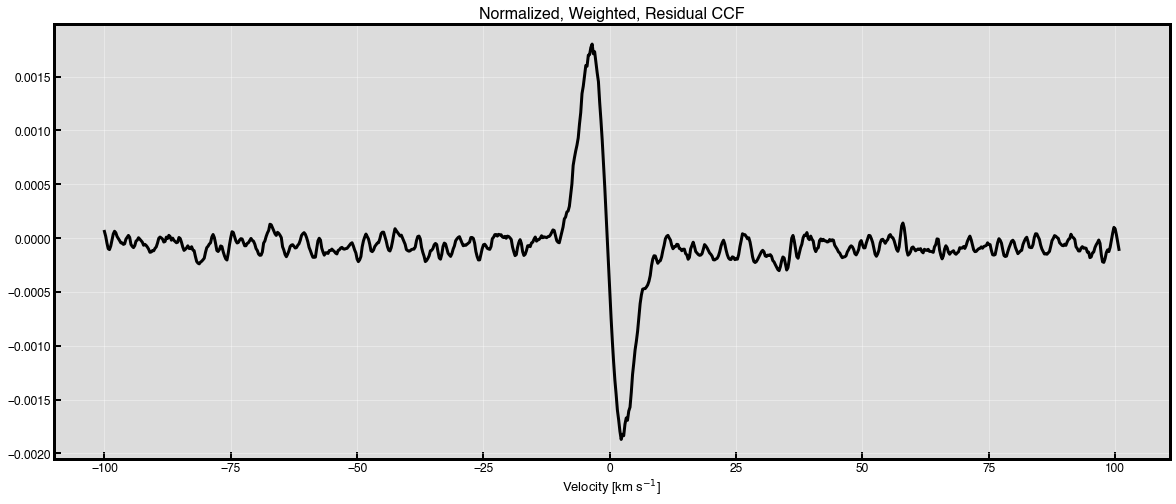

In [248]:
# calculate residual CCF
r_ccf_weighted = ccf_shift - q_ccf_shift

# normalize
# r_ccf_weighted = r_ccf_weighted - np.nanmedian(r_ccf_weighted)
# r_ccf_weighted /= np.std(r_ccf_weighted)

# plot
plt.plot(q_vel_arr, r_ccf_weighted, c='black', linewidth=3)
plt.title('Normalized, Weighted, Residual CCF')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()

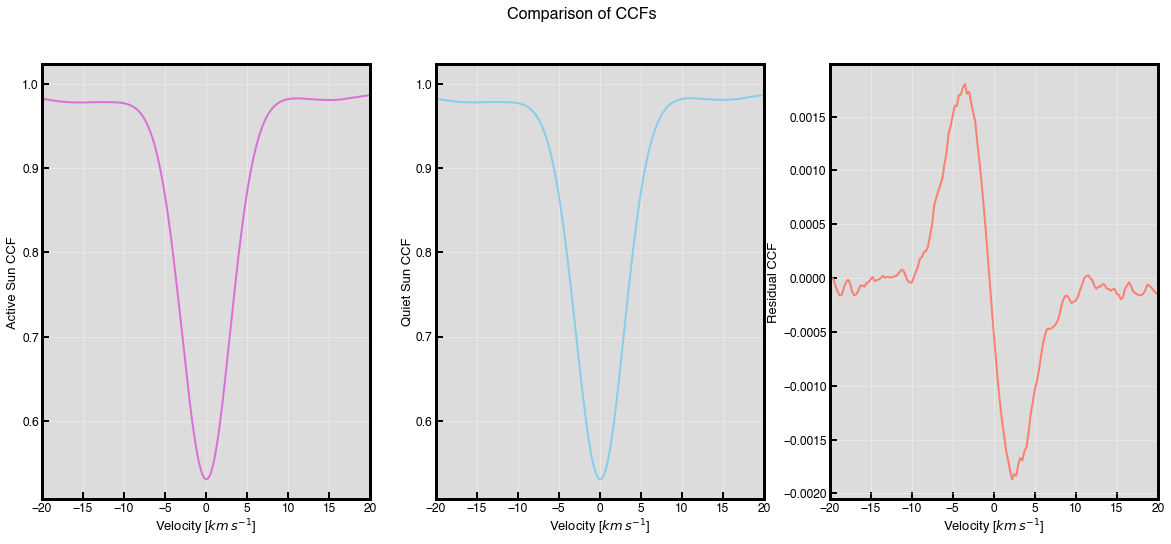

In [249]:
# plot them
fig, axs = plt.subplots(1, 3, sharex='all', gridspec_kw={'hspace': 0.1})
plt.rcParams['figure.figsize'] = [20, 8]
axs[0].plot(vel_arr, ccf_shift, c='orchid', linewidth=2)
axs[1].plot(q_vel_arr, q_ccf_shift, c='skyblue', linewidth=2)
axs[2].plot(q_vel_arr, r_ccf_weighted, c='salmon', linewidth=2)
axs[0].set_ylabel('Active Sun CCF')
axs[1].set_ylabel('Quiet Sun CCF')
axs[2].set_ylabel('Residual CCF')
axs[0].set_xlabel('Velocity [$km\/s^{-1}$]')
axs[1].set_xlabel('Velocity [$km\/s^{-1}$]')
axs[2].set_xlabel('Velocity [$km\/s^{-1}$]')
plt.xlim(-20, 20)
plt.suptitle('Comparison of CCFs')
fig.align_ylabels(axs)
# plt.savefig(os.path.join(ImgDir.CCF_IMG, 'residual_ccfs.png'))

In [250]:
# stellar activity signal
stellar = np.average(r_ccf_weighted, weights = q_vel_arr)
print('The stellar activity signal is', np.around(stellar * 1000, 3), 'm/s')

# compare to model stellar RV
model = np.isin(dates, date)
model = rv_model[model]
print('RV Sun:', np.around(rv_shift * 1000), '\nRV Model:', np.around(model[0] * 1000, 3))
print('SDO Derived RV Difference:', np.around((rv_shift - model[0]) * 1000, 3), 'm/s')

The stellar activity signal is -2.557 m/s
RV Sun: -639.0 
RV Model: -641.763
SDO Derived RV Difference: 2.891 m/s
